In [5]:
### Setup

In [52]:
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np
import _pickle as cp
import matplotlib.pyplot as plt
import pandas as pd
import sklearn.metrics as metrics

import torch
from torch import nn
from torch.nn import Module
import torch.nn.functional as F

NB_SENSOR_CHANNELS = 113
SLIDING_WINDOW_LENGTH = 24
SLIDING_WINDOW_STEP = 12

In [7]:
#pip install data

In [8]:
import os
import sys

## Load Data

In [9]:
data1 = pd.read_table('phoneaccel.txt',names=('Subject-id', 'Activity Label', 'Timestamp', 'x', 'y', 'z'),sep=',')
data2 = pd.read_table('phonegyro.txt',names=('Subject-id', 'Activity Label', 'Timestamp', 'x', 'y', 'z'),sep=',')

In [10]:
#merging all dataframes
frames = [data1,data2]
data = pd.concat(frames)
data.shape

(6174062, 6)

In [11]:
#function to return basic eda
def basic_eda(df):
    print('==========================================ROW===============================================')
    print(df.head())
    print('==========================================ROW===============================================')
    print(df.tail())
    print('==========================================ROW===============================================')
    print(df.info())
    print('==========================================ROW===============================================')
    print(df.dtypes)
    print('==========================================ROW===============================================')
    print(df.describe())
    print('==========================================ROW===============================================')
    print(df.isna().sum())
    print('==========================================ROW===============================================')
    print(df.isnull().sum())
    print('==========================================ROW===============================================')
    print(df.shape)

In [12]:
basic_eda(data)

==========================================ROW===============================================
  Subject-id Activity Label     Timestamp         x          y            z
0       1600              A  2.522077e+14 -0.364761   8.793503   1.0550842;
1       1600              A  2.522077e+14 -0.879730   9.768784   1.0169983;
2       1600              A  2.522078e+14  2.001495  11.109070    2.619156;
3       1600              A  2.522078e+14  0.450623  12.651642  0.18455505;
4       1600              A  2.522079e+14 -2.164352  13.928436  -4.4224854;
==========================================ROW===============================================
        Subject-id Activity Label     Timestamp         x         y  \
1369653       1619              P  1.739443e+14 -0.282295 -0.335558   
1369654       1619              P  1.739443e+14 -0.524110 -0.634898   
1369655       1619              P  1.739443e+14 -0.532632 -0.763795   
1369656       1619              P  1.739444e+14 -0.255663 -0.641289   
136

In [13]:
#since the datatype of column z is object because of ';', we will now remove the ';' and convert it to float datatype
data['z']= data.z.str.replace(';','').astype('float')
data.dtypes

Subject-id         object
Activity Label     object
Timestamp         float64
x                 float64
y                 float64
z                 float64
dtype: object

In [14]:
data.columns = data.columns.str.strip()

In [15]:
#function to return lsit of columns
def colname(df):
    for col in df.columns:
        print(col)

In [16]:
colname(data)

Subject-id
Activity Label
Timestamp
x
y
z


In [17]:
#dictionary of actual activites
labels = { 'A':'walking' ,'B':'jogging' ,'C':'stairs', 'D':'sitting','E':'standing','F':'typing', 'G':'brushing teeth', 'H':'drinking soup', 'I':'eating chips','J':'eating pasta','K':'drinking', 'L':'eating sandwich', 'M':'kicking','O':'catch','P':'dribbling','Q':'writing','R':'clapping','S':'folding','0':'not recognisable'}

In [18]:
#replacing pseudo activity labels with actual activity labels
data = data.replace({'Activity Label': labels})
data.head()

,Subject-id,Activity Label,Timestamp,x,y,z
0,1600,walking,2.522077e+14,-0.364761,8.793503,1.055084
1,1600,walking,2.522077e+14,-0.879730,9.768784,1.016998
2,1600,walking,2.522078e+14,2.001495,11.109070,2.619156
3,1600,walking,2.522078e+14,0.450623,12.651642,0.184555
4,1600,walking,2.522079e+14,-2.164352,13.928436,-4.422485


In [19]:
#since activity label has just once value as 0 
#to remove it lets find the index number of the specific row
data.loc[data['Activity Label']== 0]

,Subject-id,Activity Label,Timestamp,x,y,z


In [20]:
#row number is 4804403 and now we will drop it
data = data.drop(4804403)

## Data Balancing

In [21]:
data['Subject-id'].value_counts().min()
data['Subject-id'].value_counts()

1614    247195
1603    163040
1613    162884
1601    162650
1605    162462
1641    160798
1646    160792
1648    160791
1645    160783
1608    160772
1644    160771
1627    155101
1616    154571
1607    153391
1643    151834
1602    149176
1610    145114
1619    145004
1642    142929
1629    139346
1635    128852
1615    128563
1611    128561
1600    128558
1612    128558
1606    128558
1604    128557
1617    128551
1609    122285
1618    121453
1625    114850
1620    111026
1628    108362
1623     91143
1633     85955
1650     85811
1649     81975
1647     81887
1621     81688
1626     75034
1650     74968
1640     64845
1639     64840
1638     64830
1637     64801
1631     64315
1634     64309
1636     64308
1622     64308
1632     64306
1624     64302
1630     64298
Name: Subject-id, dtype: int64

In [22]:
data['Subject-id'].unique()

array([1600, 1601, 1602, 1603, 1604, 1605, 1606, 1607, 1608, 1609, 1610,
       1611, 1612, 1613, 1614, 1615, 1616, 1617, 1618, 1619, 1620, 1621,
       1622, 1623, 1624, 1625, 1626, 1627, 1628, 1629, 1630, 1631, 1632,
       1633, 1634, 1635, 1636, 1637, 1638, 1639, 1640, 1641, 1642, 1643,
       1644, 1645, 1646, 1647, 1648, 1649, 1650, '1650'], dtype=object)

In [23]:
a = data[data['Subject-id']== 1600].head(64298).copy()
b = data[data['Subject-id']== 1601].head(64298).copy()
c = data[data['Subject-id']== 1602].head(64298).copy()
d = data[data['Subject-id']== 1603].head(64298).copy()
e = data[data['Subject-id']== 1604].head(64298).copy()
f = data[data['Subject-id']== 1605].head(64298).copy()
g = data[data['Subject-id']== 1606].head(64298).copy()
h = data[data['Subject-id']== 1607].head(64298).copy()
i = data[data['Subject-id']== 1608].head(64298).copy()
j = data[data['Subject-id']== 1609].head(64298).copy()
k = data[data['Subject-id']== 1610].head(64298).copy()
l = data[data['Subject-id']== 1611].head(64298).copy()
m = data[data['Subject-id']== 1612].head(64298).copy()
n = data[data['Subject-id']== 1613].head(64298).copy()
o = data[data['Subject-id']== 1614].head(64298).copy()
p = data[data['Subject-id']== 1615].head(64298).copy()
q = data[data['Subject-id']== 1616].head(64298).copy()
r = data[data['Subject-id']== 1617].head(64298).copy()
s = data[data['Subject-id']== 1618].head(64298).copy()
t = data[data['Subject-id']== 1619].head(64298).copy()
u = data[data['Subject-id']== 1620].head(64298).copy()
v = data[data['Subject-id']== 1621].head(64298).copy()
w = data[data['Subject-id']== 1622].head(64298).copy()
x = data[data['Subject-id']== 1623].head(64298).copy()
y = data[data['Subject-id']== 1624].head(64298).copy()
z = data[data['Subject-id']== 1625].head(64298).copy()
aa = data[data['Subject-id']== 1626].head(64298).copy()
bb = data[data['Subject-id']== 1627].head(64298).copy()
cc = data[data['Subject-id']== 1628].head(64298).copy()
dd = data[data['Subject-id']== 1629].head(64298).copy()
ee = data[data['Subject-id']== 1630].head(64298).copy()
ff = data[data['Subject-id']== 1631].head(64298).copy()
gg = data[data['Subject-id']== 1632].head(64298).copy()
hh = data[data['Subject-id']== 1633].head(64298).copy()
ii = data[data['Subject-id']== 1634].head(64298).copy()
jj = data[data['Subject-id']== 1635].head(64298).copy()
kk = data[data['Subject-id']== 1636].head(64298).copy()
ll = data[data['Subject-id']== 1637].head(64298).copy()
mm = data[data['Subject-id']== 1638].head(64298).copy()
nn = data[data['Subject-id']== 1639].head(64298).copy()
oo = data[data['Subject-id']== 1640].head(64298).copy()
pp = data[data['Subject-id']== 1641].head(64298).copy()
qq = data[data['Subject-id']== 1642].head(64298).copy()
rr = data[data['Subject-id']== 1643].head(64298).copy()
ss = data[data['Subject-id']== 1644].head(64298).copy()
tt = data[data['Subject-id']== 1645].head(64298).copy()
uu = data[data['Subject-id']== 1646].head(64298).copy()
vv = data[data['Subject-id']== 1647].head(64298).copy()
ww = data[data['Subject-id']== 1648].head(64298).copy()
xx = data[data['Subject-id']== 1649].head(64298).copy()
yy = data[data['Subject-id']== 1650].head(64298).copy()
zz = data[data['Subject-id']== '1650'].head(64298).copy()

In [24]:
ddata = pd.DataFrame()

In [25]:
ddata = ddata.append([a,b,c,d,e,f,g,h,i,j,k,l,m,n,o,p,q,r,s,t,u,v,w,x,y,z,aa,bb,cc,dd,ee,ff,gg,hh,ii,jj,kk,ll,mm,nn,oo,pp,qq,rr,ss,tt,uu,vv,ww,xx,yy,zz]) 

In [26]:
ddata['Subject-id'] = ddata['Subject-id'].replace({'1650': 1651})

In [27]:
ddata['Activity Label'].value_counts()

walking            282739
brushing teeth     266036
standing           266031
jogging            264836
sitting            261020
stairs             252072
typing             242784
drinking soup      206861
eating chips       185418
drinking           171299
kicking            162058
eating pasta       160273
eating sandwich    158681
catch              137690
dribbling          101533
writing             81555
clapping            73332
folding             69278
Name: Activity Label, dtype: int64

In [28]:
drinking = ddata[ddata['Activity Label']== 'drinking'].head(69278).copy()
walking = ddata[ddata['Activity Label']== 'walking'].head(69278).copy()
kicking = ddata[ddata['Activity Label']== 'kicking'].head(69278).copy()
drinking_soup = ddata[ddata['Activity Label']== 'drinking soup'].head(69278).copy()
brushing_teeth = ddata[ddata['Activity Label']== 'brushing teeth'].head(69278).copy()
standing = ddata[ddata['Activity Label']== 'standing'].head(69278).copy()
catch = ddata[ddata['Activity Label']== 'catch'].head(69278).copy()
dribbling = ddata[ddata['Activity Label']== 'dribbling'].head(69278).copy()
eating_sandwich = ddata[ddata['Activity Label']== 'eating sandwich'].head(69278).copy()
sitting = ddata[ddata['Activity Label']== 'sitting'].head(69278).copy()
clapping = ddata[ddata['Activity Label']== 'clapping'].head(69278).copy()
eating_chips = ddata[ddata['Activity Label']== 'eating chips'].head(69278).copy()
jogging = ddata[ddata['Activity Label']== 'jogging'].head(69278).copy()
folding = ddata[ddata['Activity Label']== 'folding'].head(69278).copy()
writing = ddata[ddata['Activity Label']== 'writing'].head(69278).copy()
stairs = ddata[ddata['Activity Label']== 'stairs'].head(69278).copy()
eating_pasta = ddata[ddata['Activity Label']== 'eating pasta'].head(69278).copy()
typing = ddata[ddata['Activity Label']== 'typing'].head(69278).copy()

In [29]:
bdata = pd.DataFrame()

In [30]:
bdata = bdata.append([walking ,jogging ,stairs,sitting,standing,typing,brushing_teeth,drinking_soup,eating_chips,eating_pasta,drinking,eating_sandwich,kicking,catch,dribbling,writing,clapping,folding]) 

In [33]:
activities = data['Activity Label'].value_counts().index
activities

Index(['drinking', 'walking', 'kicking', 'drinking soup', 'brushing teeth',
       'standing', 'catch', 'dribbling', 'eating sandwich', 'sitting',
       'clapping', 'eating chips', 'jogging', 'folding', 'writing', 'stairs',
       'eating pasta', 'typing'],
      dtype='object')

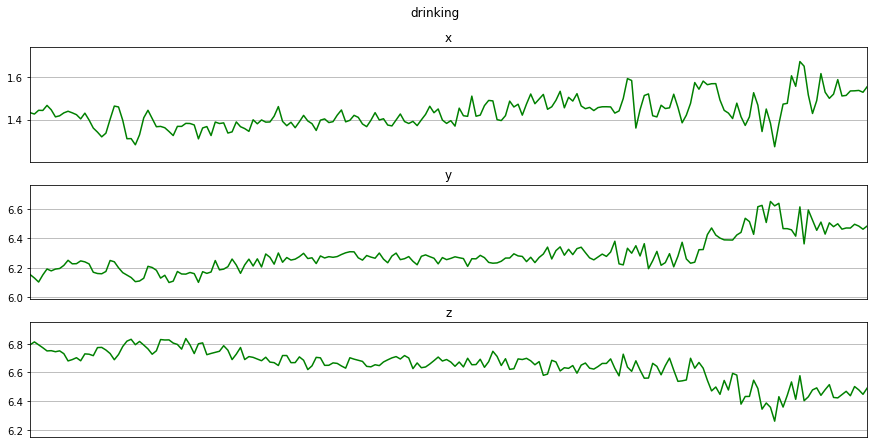

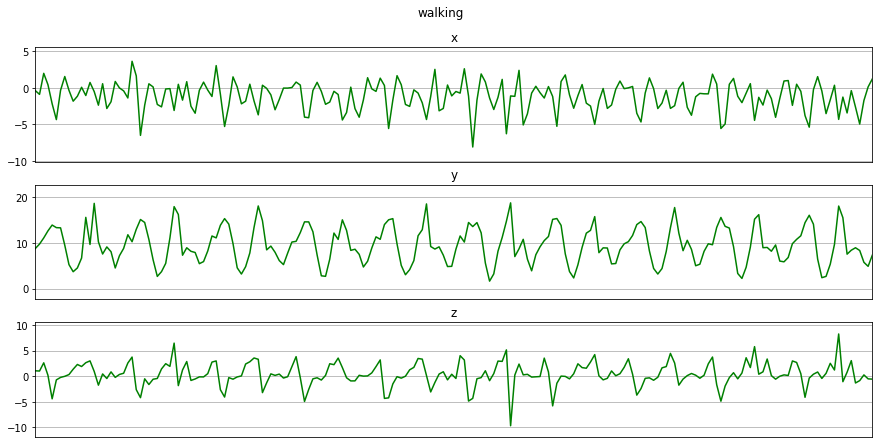

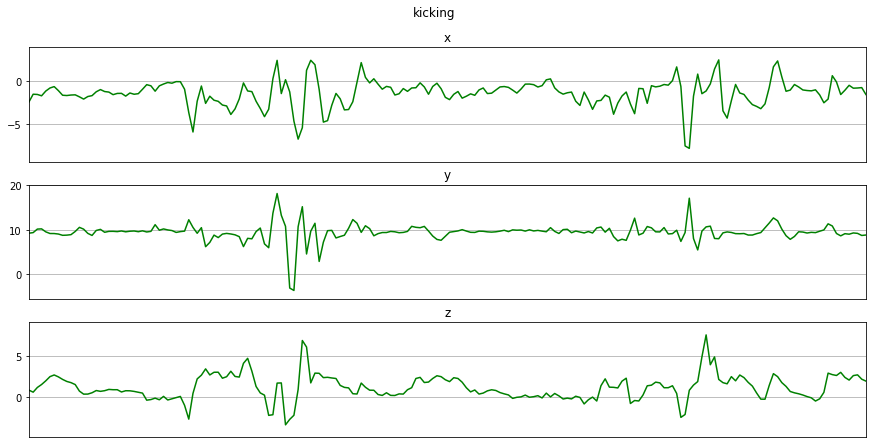

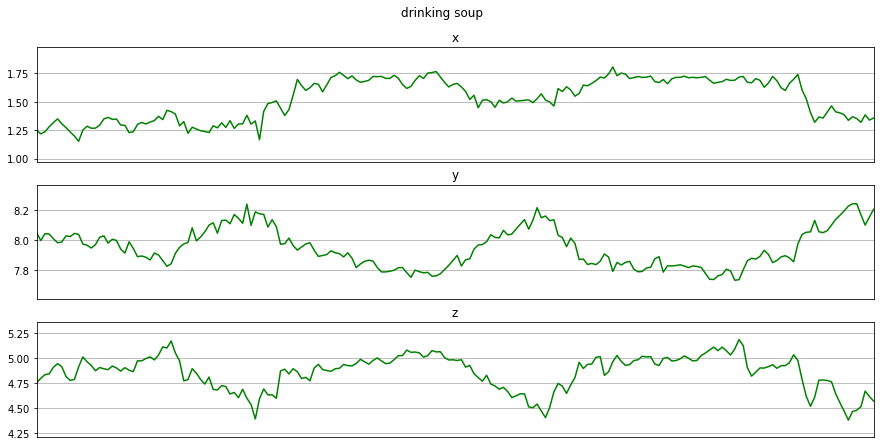

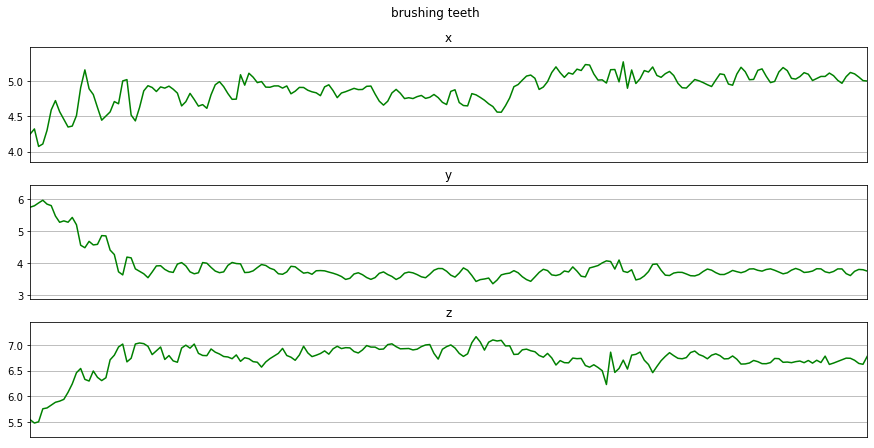

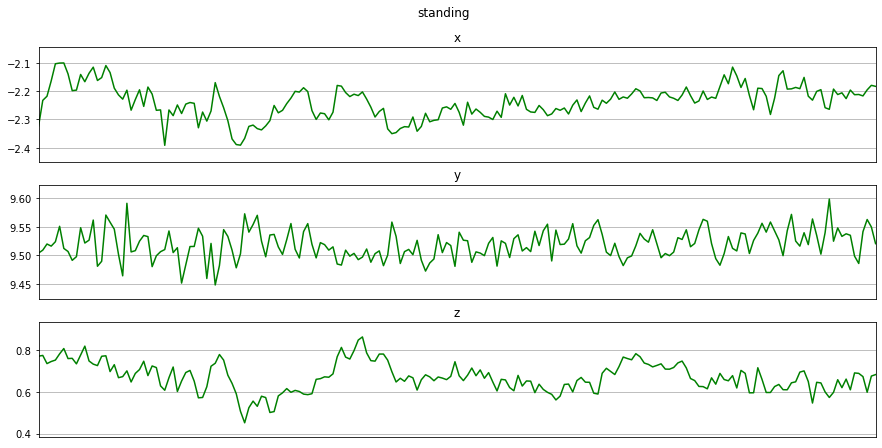

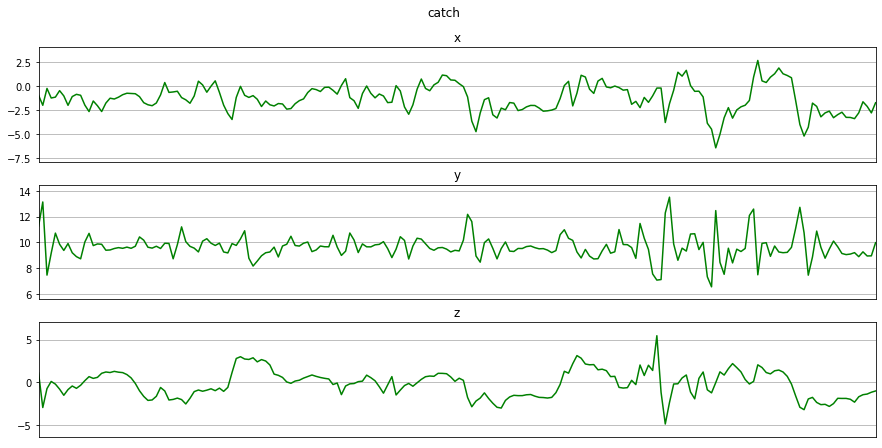

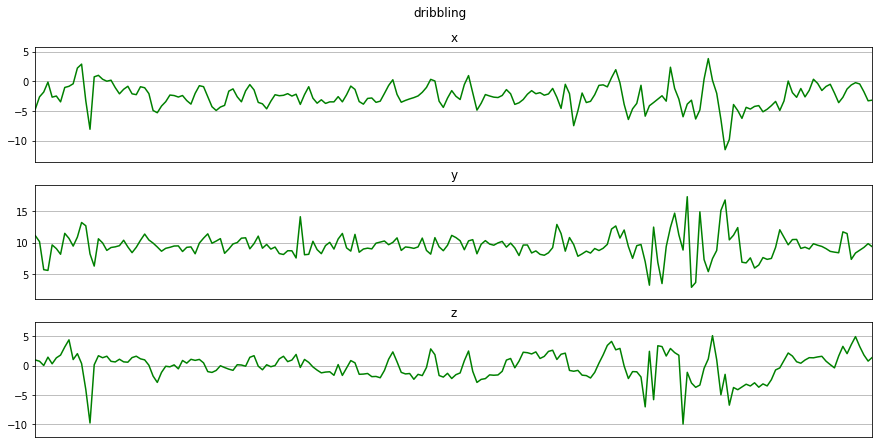

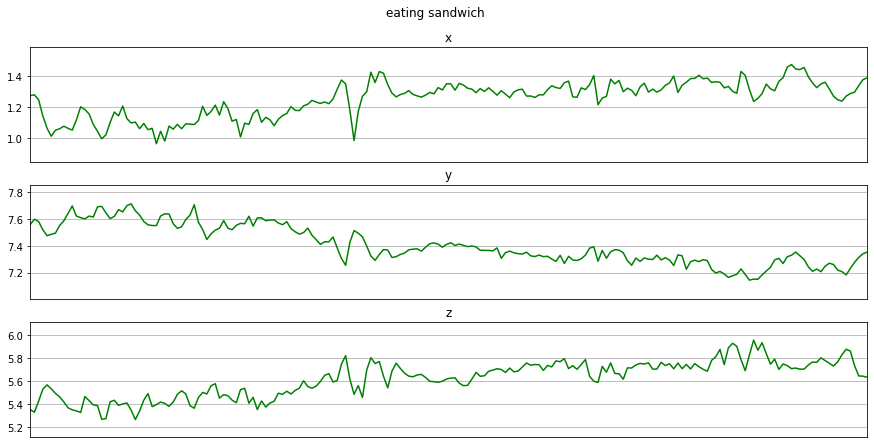

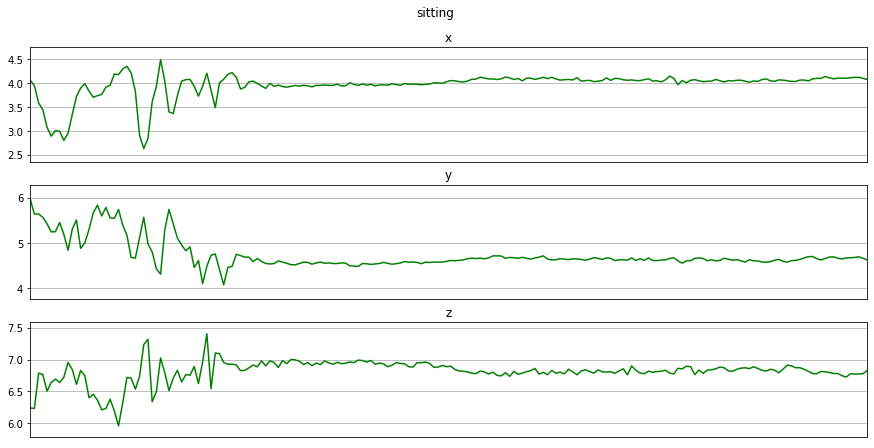

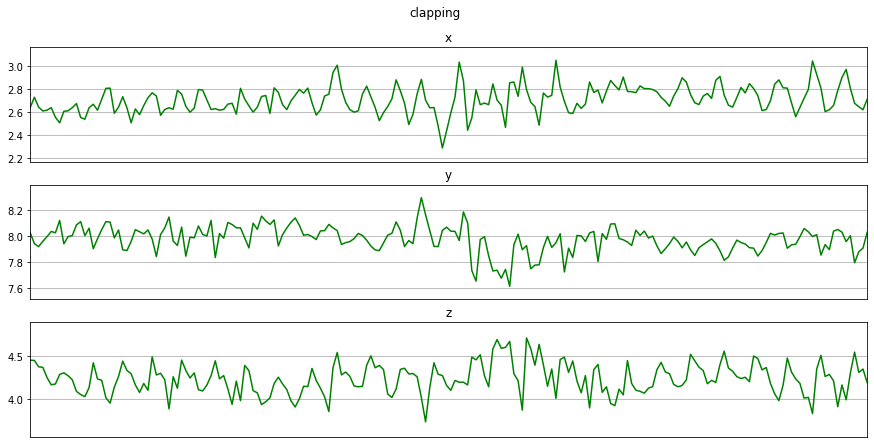

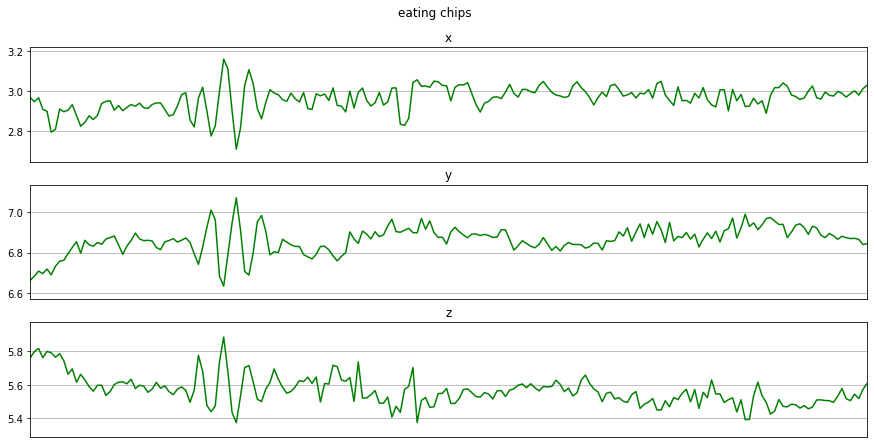

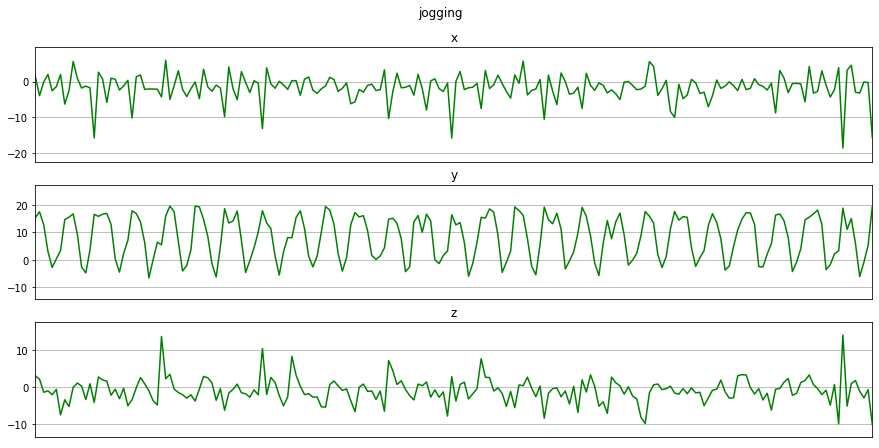

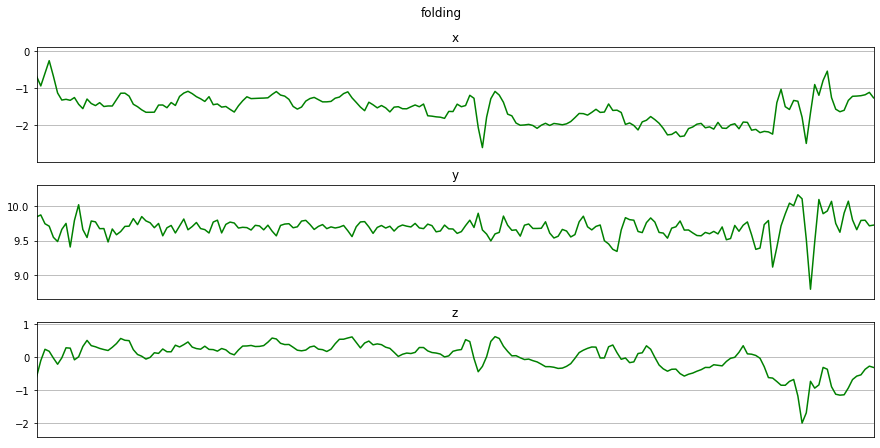

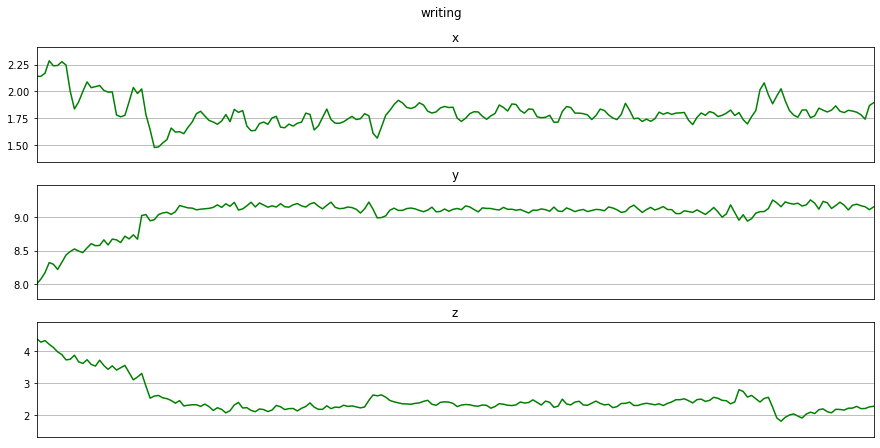

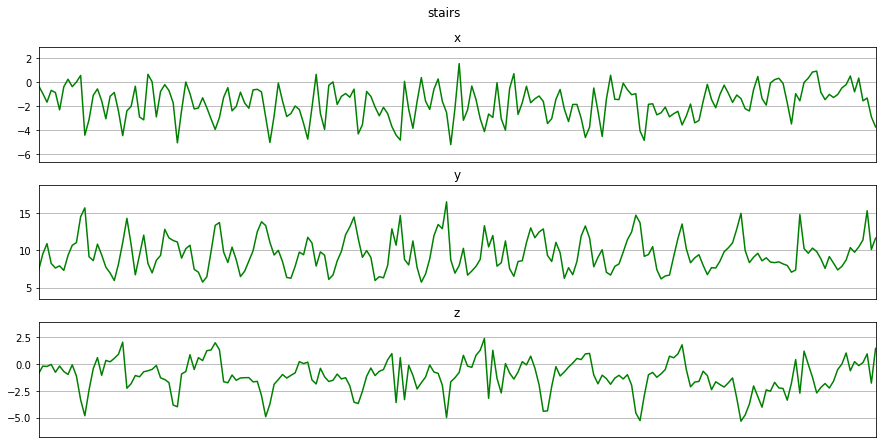

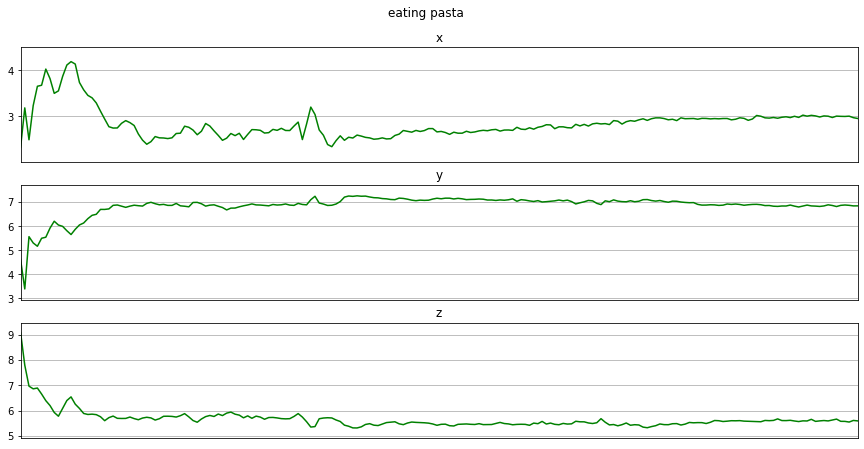

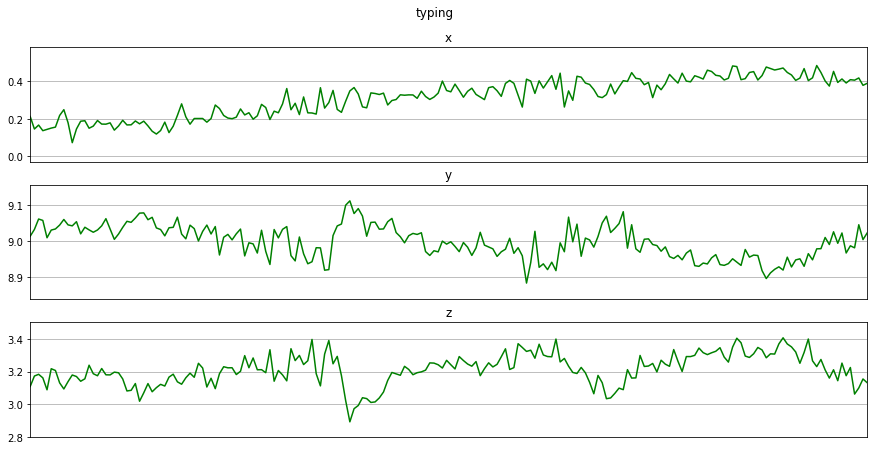

In [34]:
#plot frequnecy
Fs= 20 #since the data is recorded at frequnecy of 200Hz
def plot_axis(ax, x, y, title):
    ax.plot(x, y,'g')
    ax.set_title(title)
    ax.xaxis.set_visible(False)
    ax.set_ylim([min(y) - np.std(y), max(y) + np.std(y)])
    ax.set_xlim([min(x), max(x)])
    ax.grid(True)

def plot_activity(activity,bdata):
    fig, (ax0, ax1, ax2) = plt.subplots(nrows = 3, figsize = (15, 7), sharex = True)
    plot_axis(ax0, bdata['Timestamp'], bdata['x'], 'x')
    plot_axis(ax1, bdata['Timestamp'], bdata['y'], 'y')
    plot_axis(ax2, bdata['Timestamp'], bdata['z'], 'z')
    plt.subplots_adjust(hspace=0.2)
    fig.suptitle(activity)
    plt.subplots_adjust(top=0.90)
    plt.show()

for activity in activities:
    data_for_plot = bdata[(bdata['Activity Label'] == activity)][:Fs*10]
    plot_activity(activity,data_for_plot)

In [35]:
Data = bdata

In [36]:
Data.reset_index(drop=True, inplace=True)

In [37]:
Data.shape

(1247004, 6)

In [38]:
#data.to_csv('data.csv')

In [39]:
from sklearn.model_selection import train_test_split

In [40]:
Data= bdata.drop(['Timestamp','Subject-id'] , axis=1)
Data

,Activity Label,x,y,z
0,walking,-0.364761,8.793503,1.055084
1,walking,-0.879730,9.768784,1.016998
2,walking,2.001495,11.109070,2.619156
3,walking,0.450623,12.651642,0.184555
4,walking,-2.164352,13.928436,-4.422485
...,...,...,...,...
1246999,folding,3.679439,-9.209895,-4.233397
1247000,folding,4.108001,-9.133281,-3.814412
1247001,folding,4.220529,-8.513183,-3.539079
1247002,folding,3.732111,-7.641693,-3.136853


In [41]:
y = Data['Activity Label']
y

0          walking
1          walking
2          walking
3          walking
4          walking
            ...   
1246999    folding
1247000    folding
1247001    folding
1247002    folding
1247003    folding
Name: Activity Label, Length: 1247004, dtype: object

In [42]:
X = Data.drop(['Activity Label'],axis=1)
X

,x,y,z
0,-0.364761,8.793503,1.055084
1,-0.879730,9.768784,1.016998
2,2.001495,11.109070,2.619156
3,0.450623,12.651642,0.184555
4,-2.164352,13.928436,-4.422485
...,...,...,...
1246999,3.679439,-9.209895,-4.233397
1247000,4.108001,-9.133281,-3.814412
1247001,4.220529,-8.513183,-3.539079
1247002,3.732111,-7.641693,-3.136853


In [43]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

## Data Segmentation

In [44]:
import scipy.stats as stats

In [45]:
random_seed = 42   
n_time_steps = 50 
n_features = 3 
step = 10 
n_classes = 6 
n_epochs = 50       
batch_size = 1024   
learning_rate = 0.0025
l2_loss = 0.0015

In [46]:
segments = []
labels = []

for i in range(0,  bdata.shape[0]- n_time_steps, step):  

    xs = Data['x'].values[i: i + 50]

    ys = Data['y'].values[i: i + 50]

    zs = Data['z'].values[i: i + 50]

    label = stats.mode(Data['Activity Label'][i: i + 50])[0][0]

    segments.append([xs, ys, zs])

    labels.append(label)

#reshape the segments which is (list of arrays) to a list
reshaped_segments = np.asarray(segments, dtype= np.float32).reshape(-1, n_time_steps, n_features)

labels = np.asarray(pd.get_dummies(labels), dtype = np.float32)

In [47]:
labels

array([[0., 0., 0., ..., 0., 1., 0.],
       [0., 0., 0., ..., 0., 1., 0.],
       [0., 0., 0., ..., 0., 1., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]], dtype=float32)

In [48]:
reshaped_segments

array([[[-3.6476135e-01, -8.7973022e-01,  2.0014954e+00],
        [ 4.5062256e-01, -2.1643524e+00, -4.3327789e+00],
        [-3.1944275e-01,  1.5664520e+00, -3.2374573e-01],
        ...,
        [ 5.0408936e-01,  2.7651062e+00,  2.9900513e+00],
        [-2.6391144e+00, -4.0735626e+00, -2.7114868e-01],
        [-5.8065796e-01, -1.3917542e-01,  5.7388306e-02]],

       [[-1.1340485e+00,  9.2910767e-02, -1.0363159e+00],
        [ 7.5230408e-01, -4.9697876e-01, -2.3593750e+00],
        [ 5.8016968e-01, -2.8121796e+00, -1.8853912e+00],
        ...,
        [ 2.8281097e+00,  3.5662689e+00,  3.3124084e+00],
        [-3.2084351e+00, -1.2915192e+00,  4.5887756e-01],
        [ 1.6313171e-01,  4.1433716e-01, -3.5966492e-01]],

       [[ 4.8217773e-03, -4.0156555e-01, -1.3717194e+00],
        [ 3.6513977e+00,  1.6511078e+00, -6.4922638e+00],
        [-2.3653412e+00,  5.6820679e-01,  1.4088440e-01],
        ...,
        [ 1.8944855e+00,  3.8279877e+00, -3.0545044e-01],
        [-4.9357300e+00, -2.5

## Define the Model

In [53]:
class HARModel(Module):
    
    def __init__(self, n_hidden=128, n_layers=1, n_filters=64, 
                 n_classes=18, filter_size=5, drop_prob=0.5):
        super(HARModel, self).__init__()
        self.drop_prob = drop_prob
        self.n_layers = n_layers
        self.n_hidden = n_hidden
        self.n_filters = n_filters
        self.n_classes = n_classes
        self.filter_size = filter_size
             
        self.conv1 = nn.Conv1d(NB_SENSOR_CHANNELS, n_filters, filter_size)
        self.conv2 = nn.Conv1d(n_filters, n_filters, filter_size)
        self.conv3 = nn.Conv1d(n_filters, n_filters, filter_size)
        self.conv4 = nn.Conv1d(n_filters, n_filters, filter_size)
        
        self.lstm1  = nn.LSTM(n_filters, n_hidden, n_layers)
        self.lstm2  = nn.LSTM(n_hidden, n_hidden, n_layers)
        
        self.fc = nn.Linear(n_hidden, n_classes)

        self.dropout = nn.Dropout(drop_prob)
    
    def forward(self, x, hidden, batch_size):
        
        x = x.view(-1, NB_SENSOR_CHANNELS, SLIDING_WINDOW_LENGTH)
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = F.relu(self.conv3(x))
        x = F.relu(self.conv4(x))
        
        x = x.view(8, -1, self.n_filters)
        x, hidden = self.lstm1(x, hidden)
        x, hidden = self.lstm2(x, hidden)
        
        x = x.contiguous().view(-1, self.n_hidden)
        x = self.dropout(x)
        x = self.fc(x)
        
        out = x.view(batch_size, -1, self.n_classes)[:,-1,:]
        
        return out, hidden
    
    def init_hidden(self, batch_size):
        ''' Initializes hidden state '''
        # Create two new tensors with sizes n_layers x batch_size x n_hidden,
        # initialized to zero, for hidden state and cell state of LSTM
        weight = next(self.parameters()).data
        
        if (train_on_gpu):
            hidden = (weight.new(self.n_layers, batch_size, self.n_hidden).zero_().cuda(),
                  weight.new(self.n_layers, batch_size, self.n_hidden).zero_().cuda())
        else:
            hidden = (weight.new(self.n_layers, batch_size, self.n_hidden).zero_(),
                      weight.new(self.n_layers, batch_size, self.n_hidden).zero_())
        
        return hidden
    
net = HARModel()

## Initialize Model Weights

In [54]:
def init_weights(m):
    if type(m) == nn.LSTM:
        for name, param in m.named_parameters():
            if 'weight_ih' in name:
                torch.nn.init.orthogonal_(param.data)
            elif 'weight_hh' in name:
                torch.nn.init.orthogonal_(param.data)
            elif 'bias' in name:
                param.data.fill_(0)
    elif type(m) == nn.Conv1d or type(m) == nn.Linear:
        torch.nn.init.orthogonal_(m.weight)
        m.bias.data.fill_(0)
net.apply(init_weights)    

HARModel(
  (conv1): Conv1d(113, 64, kernel_size=(5,), stride=(1,))
  (conv2): Conv1d(64, 64, kernel_size=(5,), stride=(1,))
  (conv3): Conv1d(64, 64, kernel_size=(5,), stride=(1,))
  (conv4): Conv1d(64, 64, kernel_size=(5,), stride=(1,))
  (lstm1): LSTM(64, 128)
  (lstm2): LSTM(128, 128)
  (fc): Linear(in_features=128, out_features=18, bias=True)
  (dropout): Dropout(p=0.5, inplace=False)
)

## Generate Minibatches

In [55]:
def iterate_minibatches(inputs, targets, batchsize, shuffle=True):
    assert len(inputs) == len(targets)
    if shuffle:
        indices = np.arange(len(inputs))
        np.random.shuffle(indices)
    for start_idx in range(0, len(inputs) - batchsize + 1, batchsize):
        if shuffle:
            excerpt = indices[start_idx:start_idx + batchsize]
        else:
            excerpt = slice(start_idx, start_idx + batchsize)
        yield inputs[excerpt], targets[excerpt]

In [56]:
## check if GPU is available
train_on_gpu = torch.cuda.is_available()
if(train_on_gpu):
    print('Training on GPU!')
else: 
    print('No GPU available, training on CPU; consider making n_epochs very small.')

No GPU available, training on CPU; consider making n_epochs very small.


## Train the Network

In [60]:
def train(net, epochs=10, batch_size=100, lr=0.01):
    
    opt = torch.optim.SGD(net.parameters(), lr=lr, momentum=0.9, weight_decay=1e-4)
    criterion = nn.CrossEntropyLoss()
    
    if(train_on_gpu):
        net.cuda()
     
    for e in range(epochs):
        
        # initialize hidden state
        h = net.init_hidden(batch_size)         
        train_losses = []    
        net.train()
        for batch in iterate_minibatches(X_train, y_train, batch_size):
            x, y = batch

            inputs, targets = torch.from_numpy(x), torch.from_numpy(y)

            if(train_on_gpu):
                    inputs, targets = inputs.cuda(), targets.cuda()

            # Creating new variables for the hidden state, otherwise
            # we'd backprop through the entire training history
            h = tuple([each.data for each in h])
            
            # zero accumulated gradients
            opt.zero_grad()   
            
            # get the output from the model
            output, h = net(inputs, h, batch_size)
            
            loss = criterion(output, targets.long())
            train_losses.append(loss.item())
            loss.backward()
            opt.step()
            
        val_h = net.init_hidden(batch_size)
        val_losses = []
        accuracy=0
        f1score=0
        net.eval()
        with torch.no_grad():
            for batch in iterate_minibatches(X_test, y_test, batch_size):
                x, y = batch     

                inputs, targets = torch.from_numpy(x), torch.from_numpy(y)

                val_h = tuple([each.data for each in val_h])

                if(train_on_gpu):
                    inputs, targets = inputs.cuda(), targets.cuda()
                    
                output, val_h= net(inputs, val_h, batch_size)

                val_loss = criterion(output, targets.long())
                val_losses.append(val_loss.item())

                top_p, top_class = output.topk(1, dim=1)
                equals = top_class == targets.view(*top_class.shape).long()
                accuracy += torch.mean(equals.type(torch.FloatTensor))
                f1score += metrics.f1_score(top_class.cpu(), targets.view(*top_class.shape).long().cpu(), average='weighted')
            
        net.train() # reset to train mode after iterationg through validation data
                
        print("Epoch: {}/{}...".format(e+1, epochs),
        "Train Loss: {:.4f}...".format(np.mean(train_losses)),
        "Val Loss: {:.4f}...".format(np.mean(val_losses)),
        "Val Acc: {:.4f}...".format(accuracy/(len(X_test)//batch_size)),
        "F1-Score: {:.4f}...".format(f1score/(len(X_test)//batch_size)))

train(net)

accuracy= 90.2%
loss= 0.69%
